In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import torch
from torch import nn
import numpy as np
import timm
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torch import Tensor
from matplotlib.pyplot import figure

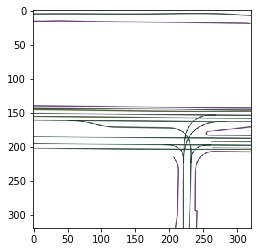

In [4]:
data = np.load("../dev_best/shard_6_10000_00000_4829295369.npz", allow_pickle = True)
raster = data['raster']
plt.imshow(raster[..., :3])

In [19]:
np.unique(raster[..., :3])

array([  0,  26,  39,  77,  89, 140, 153, 191, 255], dtype=uint8)

In [20]:
np.unique(raster[..., 3:3+2*11:2]), raster[..., 3:3+2*11:2].shape

(array([  0, 102], dtype=uint8), (224, 224, 11))

In [21]:
np.unique(raster[..., 3 + 1:3+2*11 + 1:2]), raster[..., 3 + 1:3+2*11 + 1:2].shape

(array([ 0, 68, 71, 72, 73, 74, 75, 76, 81], dtype=uint8), (224, 224, 11))

In [22]:
np.unique(raster[..., 3 + 2*11:3+2*11 + 2*11:2]), raster[..., 3 + 2*11:3+2*11 + 2*11:2].shape

(array([  0, 102, 204], dtype=uint8), (224, 224, 11))

In [23]:
np.unique(raster[..., 3 + 2*11 + 1:3+2*11 + 2*11 + 1:2]), raster[..., 3 + 2*11 + 1:3+2*11 + 2*11 + 1:2].shape

(array([  0,   1,   2,   5,   7,   8,  10,  11,  13,  21,  22,  25,  26,
         27,  28,  29,  30,  31,  32,  34,  35,  36,  38,  39,  40,  41,
         42,  43,  45,  46,  47,  48,  49,  50,  51,  52,  54,  58,  59,
         60,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         75,  76,  77,  78,  79,  80,  82,  83,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  96,  99, 100, 102, 103, 105, 106, 107, 108,
        112, 114, 116, 118, 121, 122, 126, 128, 130, 131], dtype=uint8),
 (224, 224, 11))

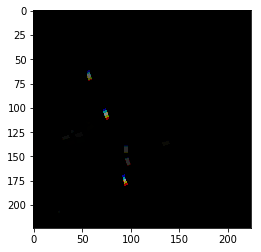

In [16]:
plt.imshow(raster[..., 3 + 2*11 + 1:3+2*11 + 2*11 + 1:2][..., 0:3])

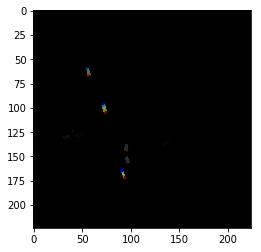

In [17]:
plt.imshow(raster[..., 3 + 2*11 + 1:3+2*11 + 2*11 + 1:2][..., 3:6])

In [3]:
from train import pytorch_neg_multi_log_likelihood_batch, N_TRAJS, TL, WaymoLoader, get_model

In [4]:
model = get_model("xception71", in_ch=47).cuda()  # seresnext50_32x4d
checkpoint = torch.load("./test_xception71_263000_dev_131.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

XceptionAligned(
  (stem): Sequential(
    (0): ConvBnAct(
      (conv): Conv2d(47, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (act): ReLU(inplace=True)
      )
    )
    (1): ConvBnAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (act): ReLU(inplace=True)
      )
    )
  )
  (blocks): Sequential(
    (0): XceptionModule(
      (shortcut): ConvBnAct(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (stack): Sequential(
        (act1): ReLU()
        (conv1): SeparableConv2d(
          (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [5]:
loader = DataLoader(
    WaymoLoader("/home/brodt/kaggle/waymo/dev/", return_vector=True),
    batch_size=1,
    num_workers=1,
    shuffle=False,
)

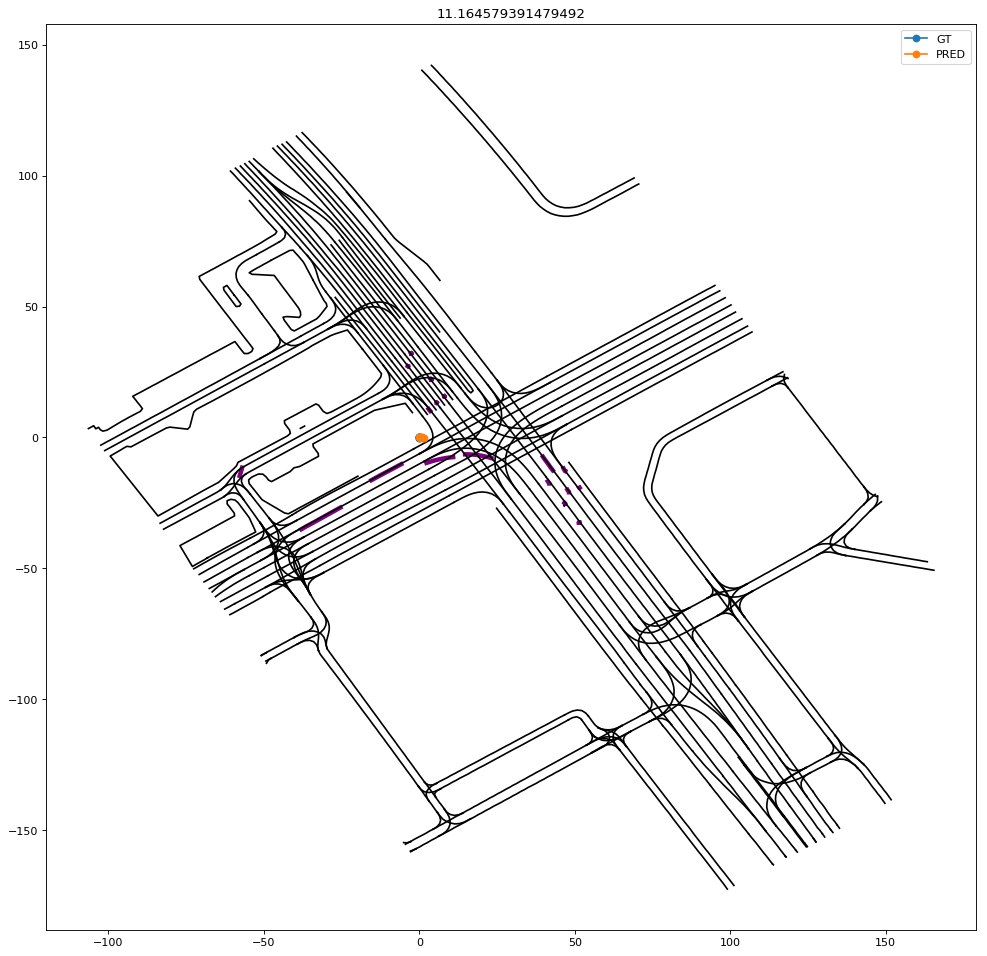

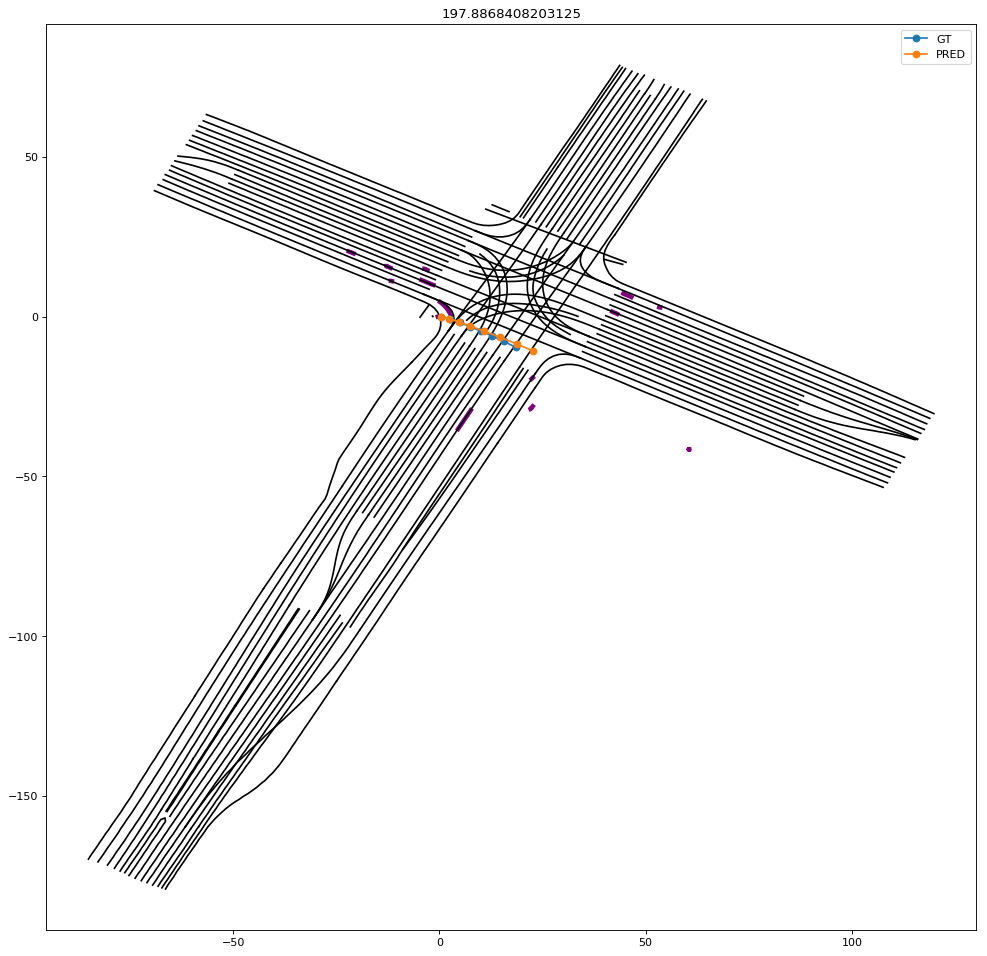

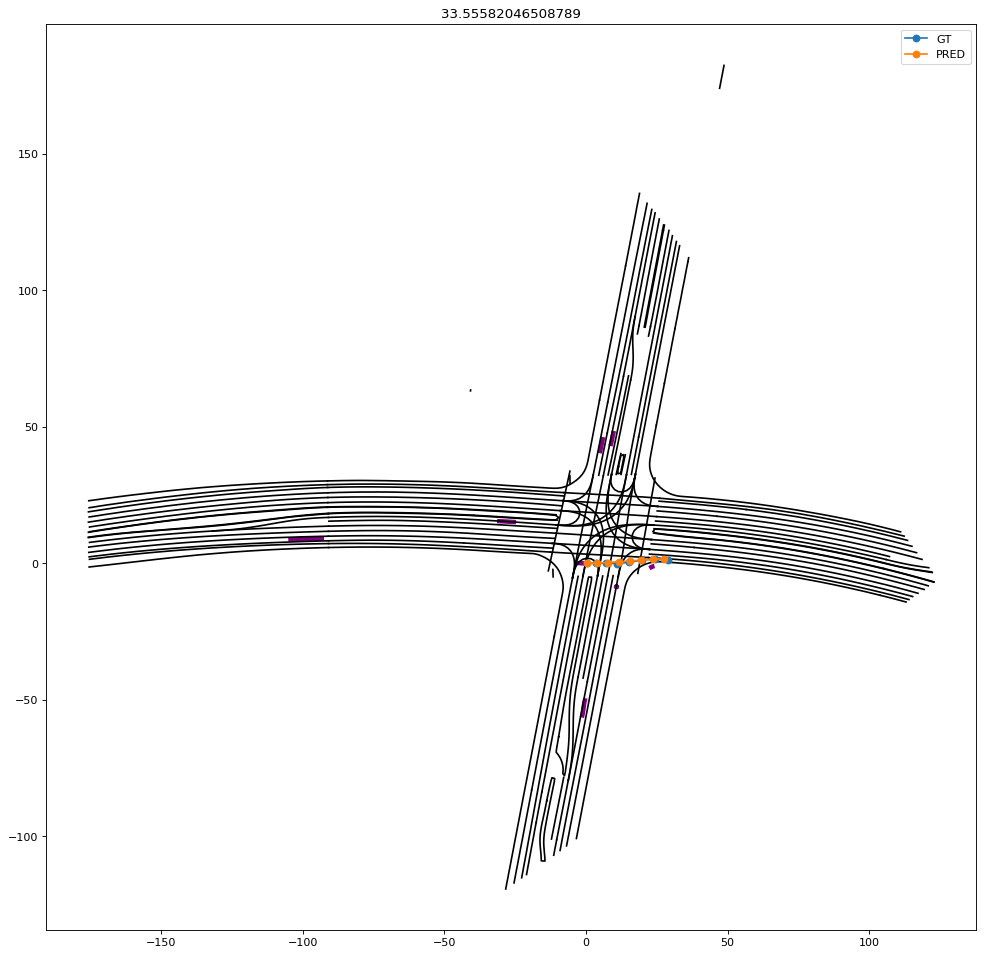

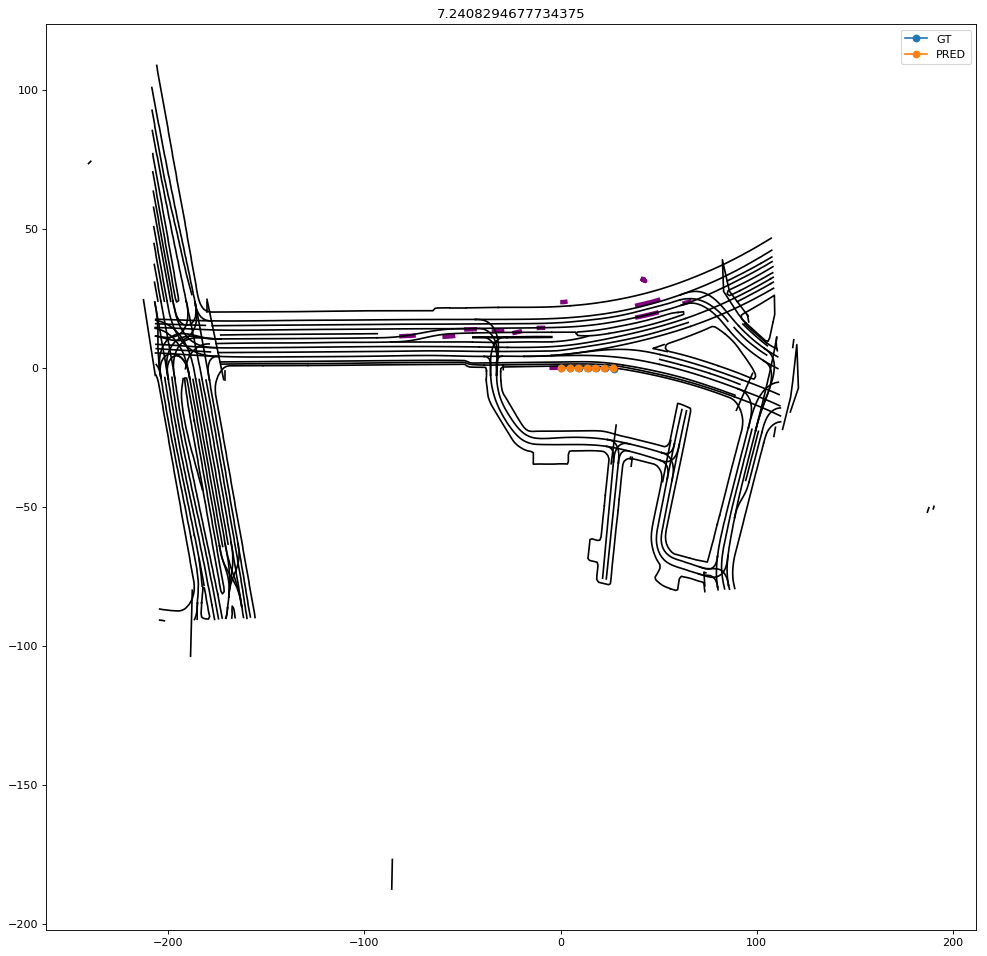

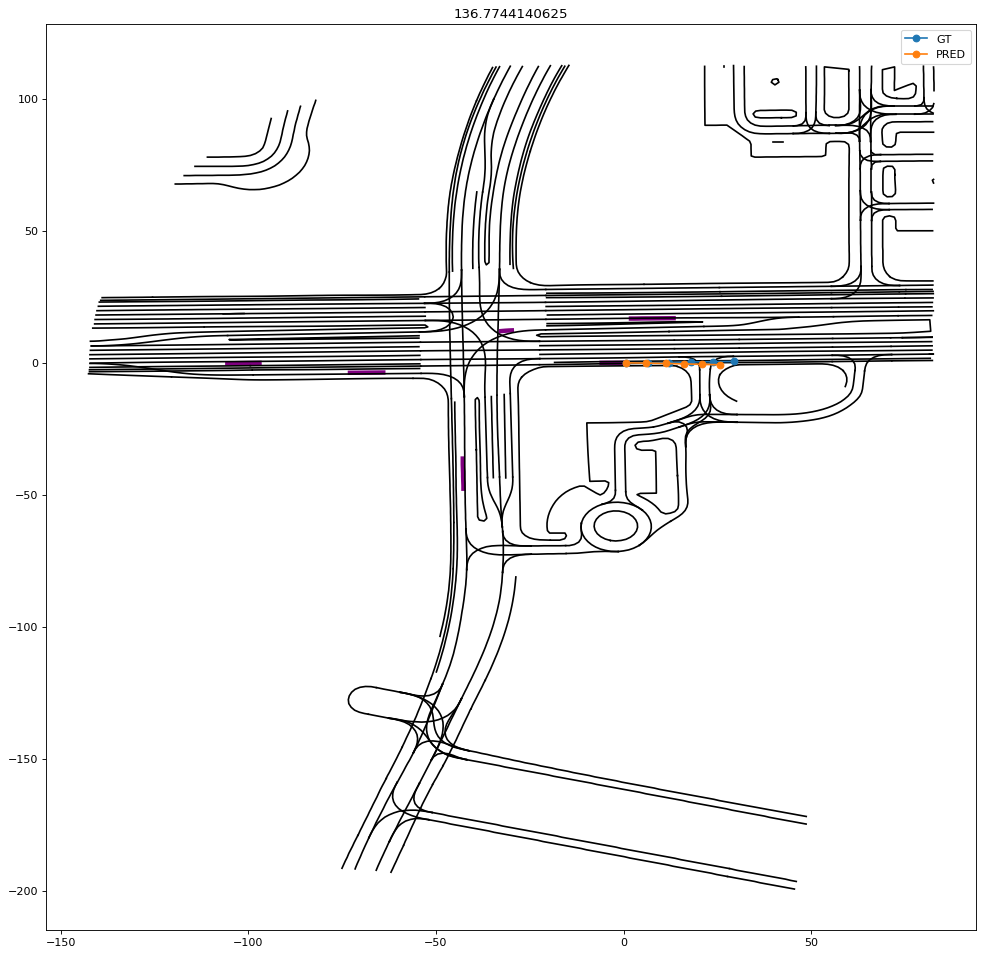

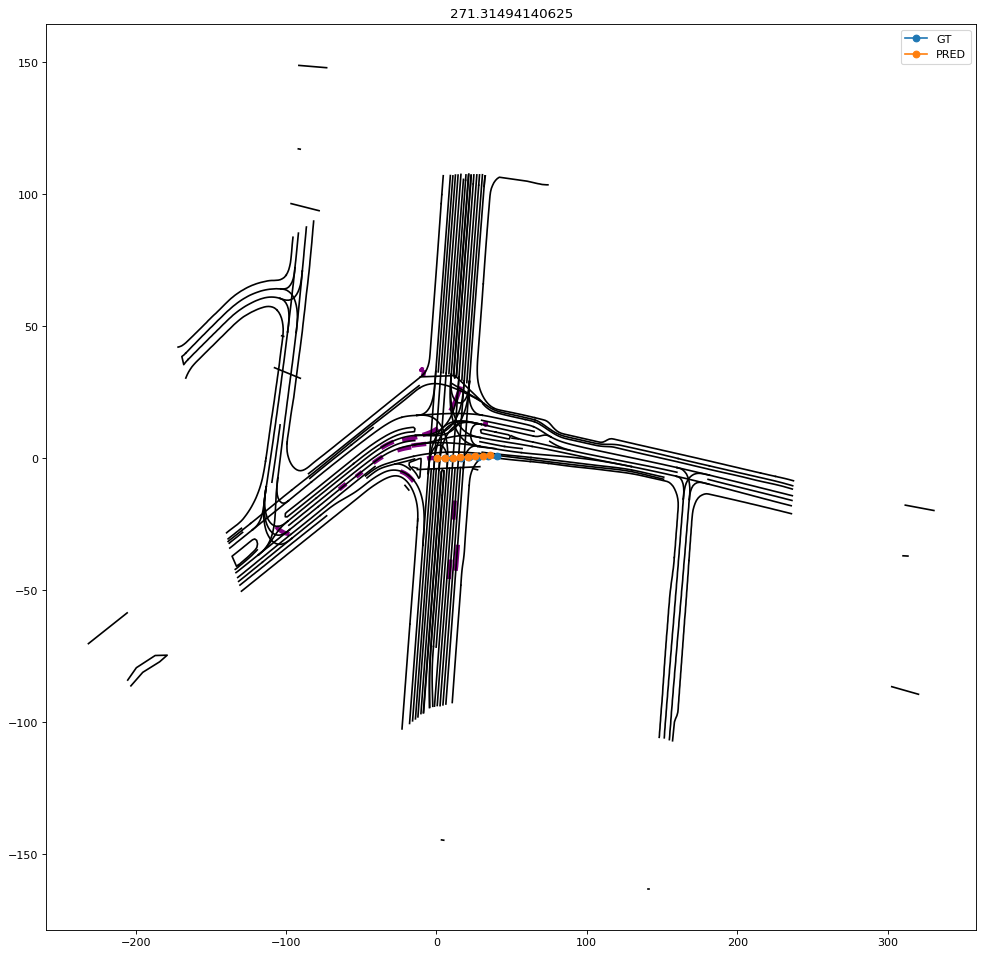

KeyboardInterrupt: 

In [6]:
iii = 0
with torch.no_grad():
    for RASTER, TRAJ, VALID, vector_data in loader:
        outputs = model(RASTER.cuda())
        confidences, pred = outputs[:,:N_TRAJS], outputs[:,N_TRAJS:]
        pred = pred.view(1, N_TRAJS, TL, 2)
        
        argmax = confidences.argmax()
        confidences = confidences[:, argmax].unsqueeze(1)
        pred = pred[:, argmax].unsqueeze(1)
        loss = pytorch_neg_multi_log_likelihood_batch(TRAJ.cuda(), pred, confidences, VALID.cuda())
        confidences = torch.softmax(confidences, dim=1)
        V = vector_data[0]
        X, idx = V[:, :44], V[:, 44].flatten()
        
        figure(figsize=(15, 15), dpi=80)
        for i in np.unique(idx):
            _X = X[idx == i]
            if _X[:, 5:12].sum() > 0:
                plt.plot(_X[:, 0], _X[:, 1], linewidth=4, color="purple")
            else:
                plt.plot(_X[:, 0], _X[:, 1], color="black")

        pred = pred.cpu().numpy()[0]
        VALID = VALID.long()
        plt.plot(
            TRAJ[0][VALID[0] > 0].cpu().numpy()[::10, 0],
            TRAJ[0][VALID[0] > 0].cpu().numpy()[::10, 1],
            "-o",
#             linewidth=7,
            label="GT",
        )
        
        plt.plot(
            pred[confidences[0].argmax()][VALID[0].cpu().numpy() > 0][::10, 0],
            pred[confidences[0].argmax()][VALID[0].cpu().numpy() > 0][::10, 1],
            "-o",
#             linewidth=7,
            label="PRED",
        )

#         for traj_pred_idx in range(N_TRAJS):
#             plt.plot(
#                 pred[traj_pred_idx][VALID[0].cpu().numpy() > 0][:, 0],
#                 pred[traj_pred_idx][VALID[0].cpu().numpy() > 0][:, 1],
#                 linewidth=7,
#                 alpha=confidences[0, traj_pred_idx].item(), 
#                 label=np.round(confidences[0, traj_pred_idx].item(), 2)
#             )

        plt.title(loss.item())
        plt.legend()
        plt.show()
        plt.close()
        iii += 1
        if iii == 50:
            break

In [122]:
RASTER = torch.Tensor(data["raster"].transpose(2,0,1)[None,]) / 255.
with torch.no_grad():
    outputs = model(RASTER.cuda())
    confidences, pred = outputs[:,:3], outputs[:,3:]
    confidences = torch.softmax(confidences, dim=1)

In [123]:
pred = pred.view(1, 3, 80, 2)

RuntimeError: shape '[1, 3, 80, 2]' is invalid for input of size 1285

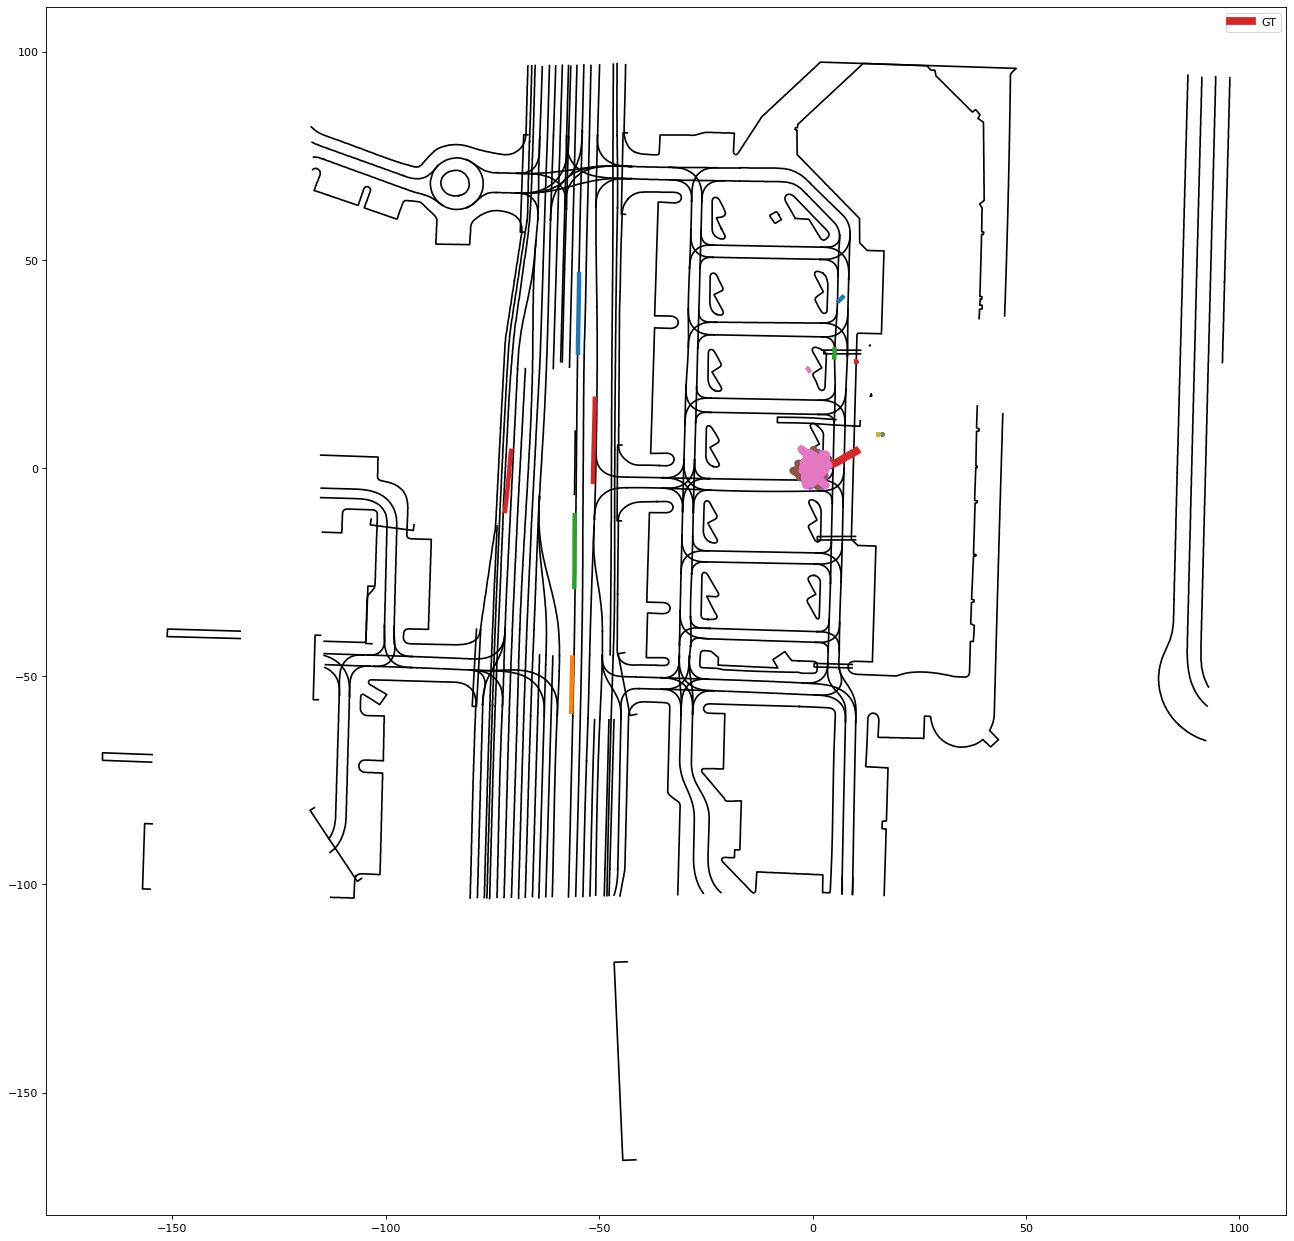

In [18]:
V = data["vector_data"]
X, idx = V[:, :44], V[:, 44]

from matplotlib.pyplot import figure
figure(figsize=(20, 20), dpi=80)

for i in np.unique(idx)[::-1]:
    _X = X[idx == i]
    if _X[:, 5:12].sum() > 0:
        plt.plot(_X[:, 0], _X[:, 1], linewidth = 4)
    else:
        plt.plot(_X[:, 0], _X[:, 1], color = "black")
    
# pred = pred.cpu().detach().numpy()[0]

plt.plot(data["gt_marginal"][:, 0], data["gt_marginal"][:, 1], linewidth = 7, label = "GT")
# pred = pred * 10
plt.plot(pred[0][:, 0], pred[0][:, 1], linewidth = 7)
plt.plot(pred[1][:, 0], pred[1][:, 1], linewidth = 7)
plt.plot(pred[2][:, 0], pred[2][:, 1], linewidth = 7)

plt.legend()

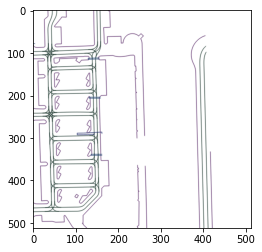

In [14]:
plt.imshow(data["raster"][:,:,:3])

In [38]:
pred[0][:, 1]

array([-0.06694981, -0.32269806, -0.08323088,  0.12191337, -0.03312419,
       -0.27929977, -0.02921964, -0.11456412,  0.30355835, -0.16803373,
       -0.27288213, -0.06886771, -0.12506542,  0.03080074, -0.02520977,
       -0.13338035, -0.10228334, -0.02856075,  0.11413591, -0.07378416,
       -0.0497802 ,  0.02459359,  0.08415255, -0.03667936,  0.02776099,
        0.15729617, -0.05156054,  0.04816671, -0.00378106,  0.14683458,
        0.00564018, -0.04319126,  0.15286891,  0.09518941, -0.08640511,
       -0.1677452 , -0.05877811, -0.10455156, -0.10521349, -0.2561086 ,
        0.02086287, -0.09059834,  0.2006266 , -0.07063956, -0.12874605,
       -0.09361457,  0.17505358, -0.2081091 ,  0.10125175, -0.04084752,
        0.06034438,  0.05817284,  0.10652857, -0.08361503, -0.11711151,
       -0.12397072, -0.10342602,  0.0849365 , -0.0293575 , -0.00390083,
        0.13229047, -0.12214181, -0.08292487, -0.01780776,  0.2684588 ,
        0.14603782,  0.16384341, -0.13568991, -0.07655028, -0.07

In [43]:
data["gt_marginal"].shape

(80, 2)

In [10]:
pred

array([[[ 0.06463317,  0.0217955 ],
        [ 0.22533466,  0.03072631],
        [-0.12051903, -0.23042357],
        [ 0.00215183,  0.28897318],
        [-0.23442677, -0.22444311],
        [ 0.25232401, -0.19141698],
        [-0.01084917,  0.15361711],
        [ 0.1111792 ,  0.03965959],
        [ 0.15349539, -0.1745735 ],
        [ 0.12023212, -0.25512853],
        [-0.01673992, -0.03187118],
        [ 0.13574755, -0.06085171],
        [-0.10689571, -0.01104997],
        [-0.02506614,  0.1375011 ],
        [ 0.1272941 , -0.00508364],
        [ 0.21957842, -0.16781199],
        [-0.18745574, -0.0077182 ],
        [ 0.04938775,  0.09931622],
        [ 0.19459869,  0.13017279],
        [ 0.11924974,  0.11423863],
        [ 0.11362151,  0.19089372],
        [-0.0242423 , -0.2128284 ],
        [ 0.24878034,  0.00860309],
        [-0.04285969,  0.12864803],
        [ 0.06535894,  0.01898148],
        [ 0.08554716,  0.00207287],
        [ 0.23747738,  0.10093091],
        [ 0.1435437 , -0.119